# Goal

Analyse the sctruture of adjacency matrices and their metrics over time with a zoom in 9-11


## Main Takeaways
- The number of bills after 9-11 doubled but in two month it returns to the same levels that before
- In september, most of bills where majority in both parties (the agreed in almost everything) or decided by democrats (in this period, republicans used ot dominate the senate)
- From august until october of 2001, the adjacencies matrices do not reveal clearly the differences in behavior between the two parties. As the attack was in september, it doesn't give any evidence that they started to vote in the same way due to the attack.

> I check the `date` field because it could be the date. It comes from the `votes` API and it has a datetime attached to it so it is actually the voting time. I was affraid that it could be the time that the bill was released then in this case we could support your theory (parties get together in bad times)

In [68]:
import os
import pandas as pd
import numpy as np

import pickle
import networkx as nx

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [69]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
ALL_SUBJECT_PATH = '../data/all-votes/bills_20years.csv'
ALL_ADJACENCY_METRIS_PATH = '../data/all-votes/all_adjacency_metric.csv'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [88]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
all_bills = pd.read_csv(ALL_SUBJECT_PATH)
all_adjacency_metrics = pd.read_csv(ALL_ADJACENCY_METRIS_PATH)
all_laws['law_id'] = all_laws['vote_uri'].apply(lambda x: '_'.join(x.split('/')[4:]).split('.')[0])
all_laws = all_laws.merge(all_bills, on='law_id', how='left')
all_laws = all_adjacency_metrics.merge(all_bills, on='law_id', how='left')
all_laws['month'] = all_laws['date'].apply(lambda x: '-'.join(x.split('-')[0:2]))

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
print(len(adjacencies))

LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))

# Kendall: coeffient that mesures difference between concordante pairs and discordant pairs
all_laws['majority_republican'] = (all_laws['republican_yes'] > all_laws['republican_no']).apply(int)
all_laws['majority_democrats'] = (all_laws['democrats_yes'] > all_laws['democrats_no']).apply(int)

def who_decided(democrats_yes, democrats_no, republican_yes, republican_no, result):
    if result == 'passed':
        if democrats_yes > democrats_no and republican_yes > republican_no:
            return 'both'
        elif democrats_yes < democrats_no and republican_yes > republican_no:
            return 'republican'
        else:
            return 'democrats'
    else:
        if democrats_yes < democrats_no and republican_yes < republican_no:
            return 'both'
        elif democrats_yes > democrats_no and republican_yes < republican_no:
            return 'republican'
        else:
            return 'democrats' 
        
all_laws['final_decision'] = all_laws.apply(lambda x: who_decided(x['democrats_yes'], x['democrats_no'], x['republican_yes'], x['republican_no'], x['result_ok']), axis=1)
pd.DataFrame(all_laws['final_decision'].value_counts())

with open(ALL_ADJACENCY_PATH, 'rb') as handle:
    adjacencies = pickle.load(handle)
    
print(all_laws.shape)
print(len(adjacencies))

6834
(6834, 36)
6834


In [89]:
adjacencies_107 = dict([(k, v) for k, v in adjacencies.items() if k.split('_')[1] == '107'])
print(len(adjacencies_107))

633


In [90]:
laws_107 = all_laws[all_laws.congress.apply(lambda x: x == 107)]
print(len(laws_107))

633


In [91]:
pd.DataFrame(laws_107.result_ok.value_counts())

,result_ok
passed,435
rejected,193
undefinied,5


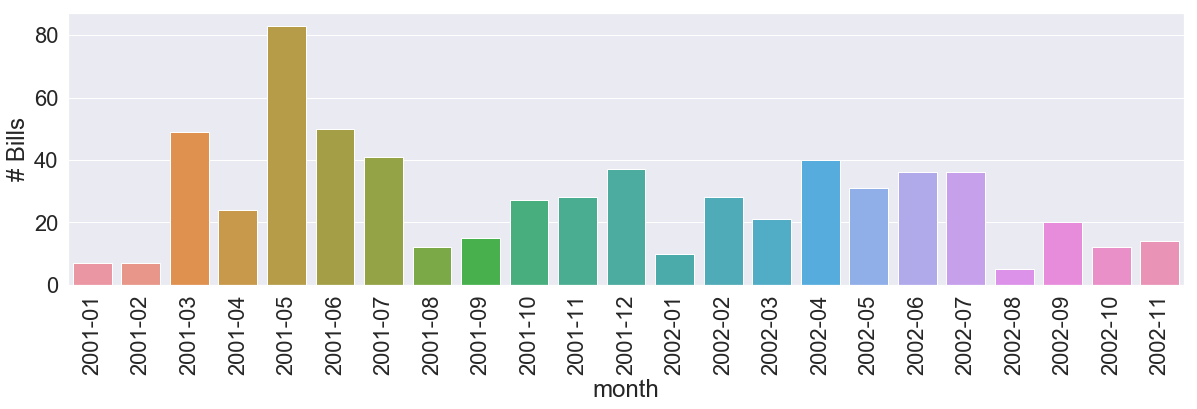

In [92]:
plt.figure(figsize=(20, 5))
d = pd.DataFrame(laws_107.groupby('month').size()).reset_index().rename(columns={0: 'count'})
sns.barplot(y='count', x='month', data=d);
plt.ylabel('# Bills');
plt.xticks(rotation=90);

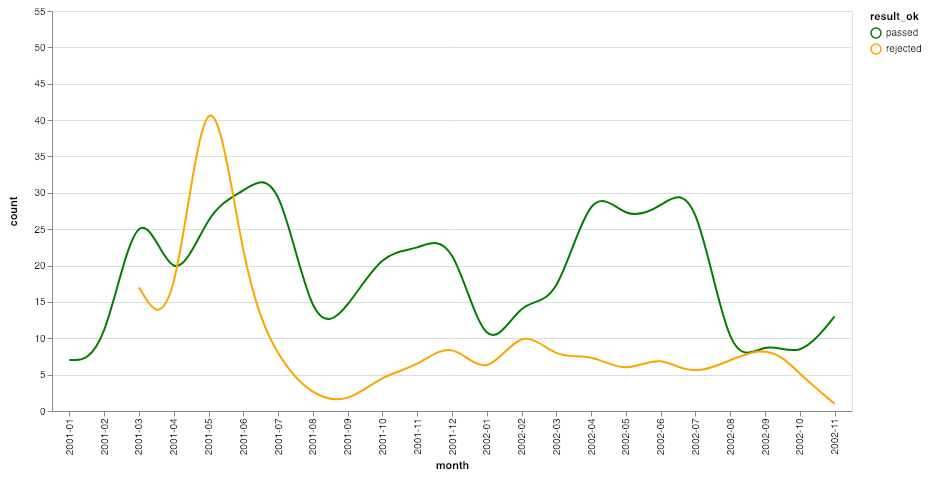

In [101]:
d = pd.DataFrame(laws_107.groupby(['month', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})

# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['month'], empty='none')
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='month:O',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))

alt.layer(line, data=d, width=800, height=400)

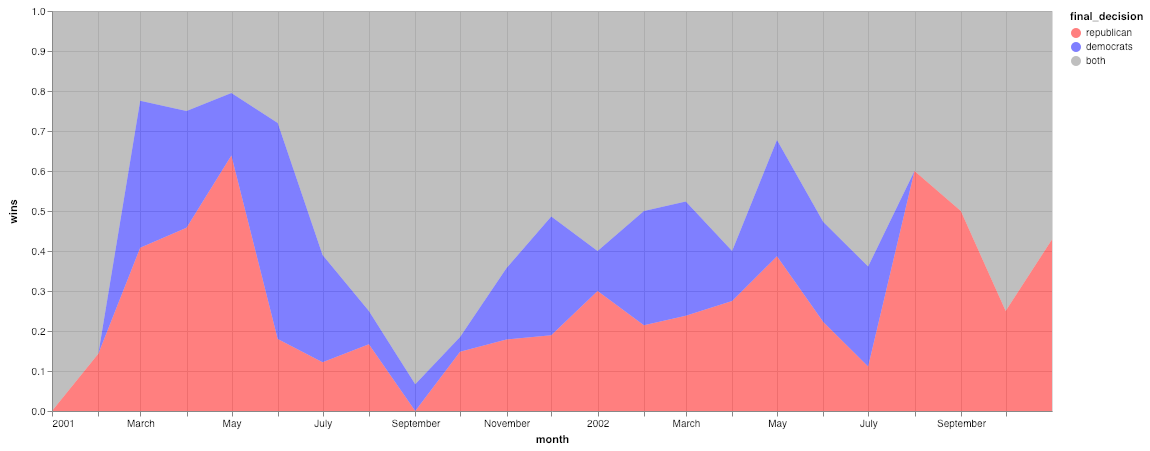

In [96]:
d = pd.DataFrame(laws_107.groupby(['month', 'final_decision']).size()).reset_index().rename(columns={0: 'wins'})
counts = pd.DataFrame(laws_107.groupby(['month']).size()).reset_index().rename(columns={0: 'total'})
d = d.merge(counts)
d['wins'] = d['wins'] / d['total']

alt.Chart(d, width=1000, height=400).mark_area(opacity=0.5).encode(
    x="month:T",
    y="wins:Q",
    color=alt.Color("final_decision:N", 
                    scale=alt.Scale(domain=['republican', 'democrats', 'both'], 
                              range=[pal['republican'], pal['democrats'], 'grey'])))

/Users/lia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


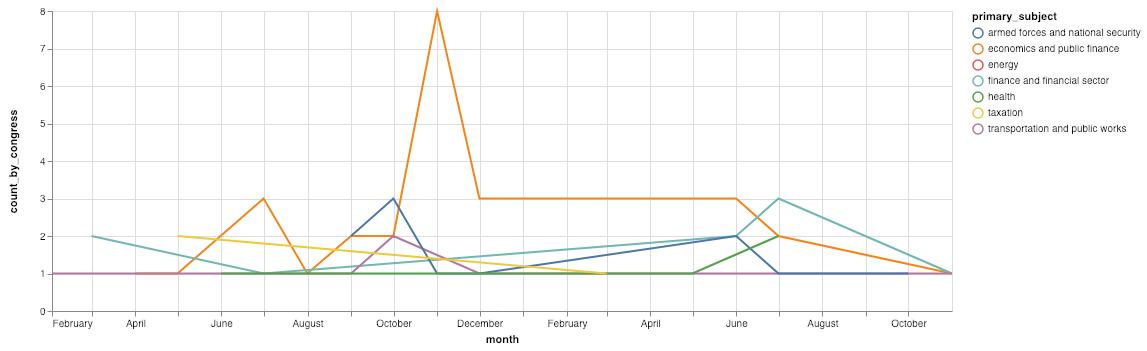

In [100]:
laws_107['primary_subject'] = laws_107['primary_subject'].str.lower()
count_by_subject = laws_107.groupby(['month', 'primary_subject']).size().reset_index().rename(columns={0: 'count_by_congress'})
total_count = all_laws.groupby('month').size().reset_index().rename(columns={0: 'count'})
d = count_by_subject.merge(total_count).sort_values(['month', 'count_by_congress'], ascending=False)
tops = ['economics and public finance', 
        'armed forces and national security', 
        'taxation', 'health', 'energy', 
        'transportation and public works', 
        'finance and financial sector', 'imigration']
d = d[d['primary_subject'].apply(lambda x: True if x in tops else False)]

alt.Chart(d, width=900, height=300).mark_line().encode(
    x='month:T',
    y='count_by_congress',
    color='primary_subject',
)

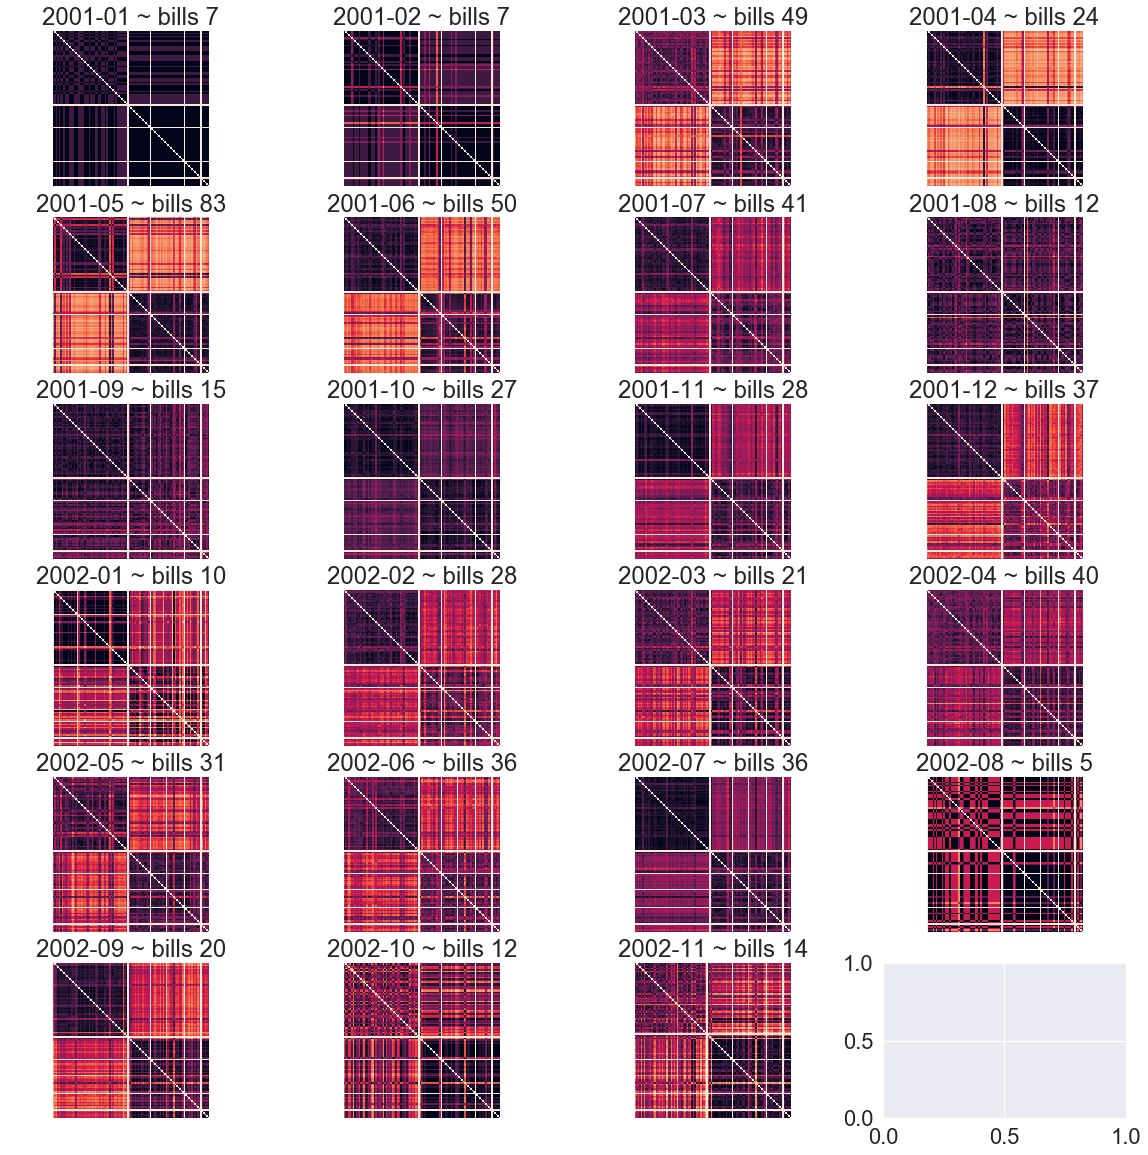

In [129]:
by = 'month'
quarters = sorted(laws_107[by].unique())
congress = laws_107['congress'].unique()

f, ax = plt.subplots(6, 4, figsize=(20, 20))
positions = np.array(range(24)).reshape(6, 4)
    
for j, q in enumerate(quarters):
    pos = np.where(positions==j)
    laws = list(laws_107[laws_107.month.apply(lambda x: x == q)]['law_id'])
    n = len(laws)
    if n > 0:
        sum_adjacencies = adjacencies[laws[0]]
        for l in laws[1:]:
            sum_adjacencies += adjacencies[l]
        
        sum_adjacencies /= n
        sum_adjacencies = 1 - sum_adjacencies # xunxo to get right color pattern
        
        ax[pos[0][0], pos[1][0]].imshow(sum_adjacencies)
    ax[pos[0][0], pos[1][0]].axis('off')
    ax[pos[0][0], pos[1][0]].set_title('{} ~ bills {}'.format(q, n))

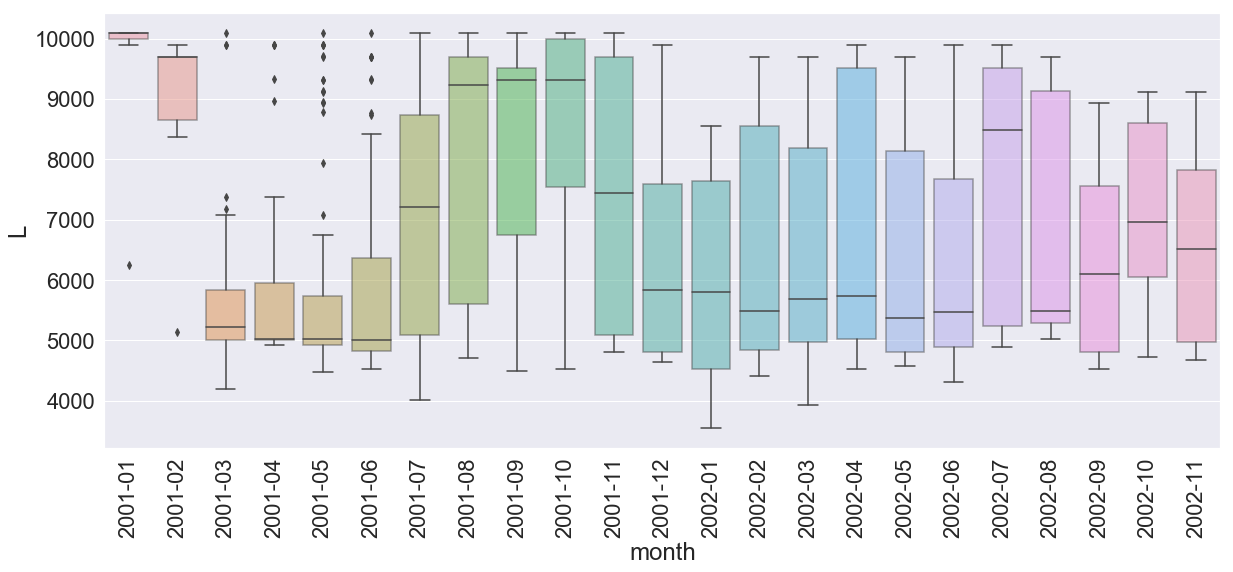

In [133]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='month', y='L', data=laws_107, boxprops=dict(alpha=.5))
plt.xticks(rotation=90);

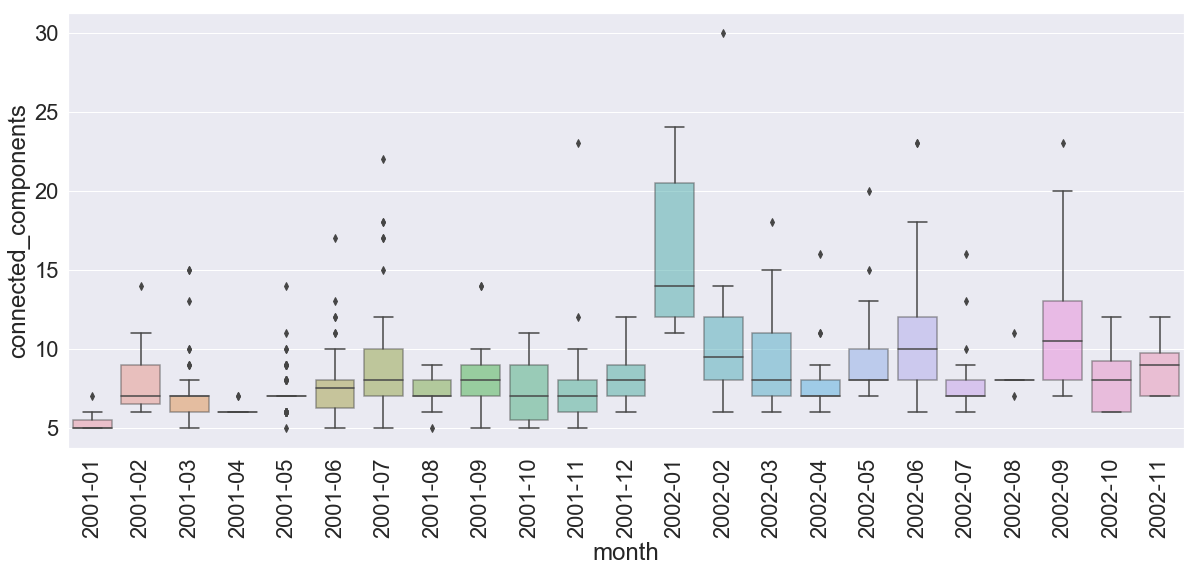

In [131]:
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='month', y='connected_components', data=laws_107, boxprops=dict(alpha=.5))
plt.xticks(rotation=90);